# Shapely value feature importance

https://medium.com/dataman-in-ai/explain-your-model-with-the-shap-values-bc36aac4de3d

https://github.com/dataman-git/codes_for_articles/blob/master/Explain%20your%20model%20with%20the%20SHAP%20values%20for%20article.ipynb

Shapley values indicate the average marginal contribution of each feature to the prediction. The contribution of each feature could be positive or negative (increasing or decreasing the predicted value) or could be 0 or 1 in case of a binary classification problem.

The benifits of using shapley values are:

1- The first one is global interpretability — the collective SHAP values can show how much each predictor contributes, either positively or negatively, to the target variable. This is like the variable importance plot but it is able to show the positive or negative relationship for each variable with the target (see the SHAP value plot below).


2- The second benefit is local interpretability — each observation gets its own set of SHAP values (see the individual SHAP value plot below). This greatly increases its transparency. We can explain why a case receives its prediction and the contributions of the predictors. Traditional variable importance algorithms only show the results across the entire population but not on each individual case. The local interpretability enables us to pinpoint and contrast the impacts of the factors.


3- Third, the SHAP values can be calculated for any tree-based model, while other methods use linear regression or logistic regression models as the surrogate models.
> since our model is a tree based model we will use SHAP TreeExplainer(), If your model is a deep learning model, use the deep learning explainer DeepExplainer(). For all other types of algorithms (such as KNNs), use KernelExplainer().

In [1]:
#!pip install shap==0.41.0
#!pip install numpy==1.21.0
#!pip freeze

In [2]:
import shap
import model_team14 
from model_team14 import *  ##select_features, plot_pca, DTW

import os
import pandas as pd
import numpy as np
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix,accuracy_score, recall_score, precision_score, f1_score,classification_report 
from sklearn.metrics import roc_curve, auc

import seaborn as sns


/Users/richardlieu/.local/share/virtualenvs/milestoneII-GYt9I6pr/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/richardlieu/.local/share/virtualenvs/milestoneII-GYt9I6pr/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-

In [3]:
# Need to load JS vis in the notebook
shap.initjs()

### Feature Importance Plot(traditional one)

In [4]:
metadata=pd.read_csv('../data/full_info.csv')
X=pd.read_csv('../data/X_data_tr.csv', index_col='date', parse_dates=True)
threshold=0.3
criteria=None

df_feature=select_features(metadata, X, threshold, criteria=criteria)

In [5]:
metadata=pd.read_csv('../data/full_info.csv')

## select imputed & transformed data
threshold=0.3   #0.2
criteria=None  #None
test_year=5
y_type='y_oecd'  #'y_agg'
dtype='tr'     #'tr'
model='clf_rf_y_oecd_tr_tss_t5_spl5'   ##'clf_lstm_y_oecd_18_b5_ep300_h50_n1_dr0', clf_rf_y_oecd_tr_tss_t5_spl5
model_name=model.split("_")[1]
time_step=18
grouping=''  ## km or None
scaling='_scaling'  ##_scaling
path='../result/ft_{}_{}{}'.format(criteria, threshold, scaling)

##'clf_rf_y_agg_tr_block_t5_spl3'
## 'clf_knn_y_oecd_tr_block_t5_spl3'
## 'clf_lstm_y_oecd_18_b5_ep300_h50_n1_dr0'

if dtype=='tr':
    X=pd.read_csv('../data/X_data_tr.csv', index_col='date', parse_dates=True)
    y=pd.read_csv('../data/y_data_tr.csv', index_col='date', parse_dates=True)
else:
    X=pd.read_csv('../data/X_data.csv', index_col='date', parse_dates=True)
    y=pd.read_csv('../data/y_data.csv', index_col='date', parse_dates=True)

print(X.shape, y.shape)
    
################# revise
if grouping=='km':
    df_feature=select_features2(metadata, X, threshold, criteria=criteria)
else:
    df_feature=select_features(metadata, X, threshold, criteria=criteria)

selected_features=list(df_feature[df_feature.select==1]['variable'])

print(selected_features)

## train and validation set: X_train, y_train / final test set: X_test, y_test
X_train=X[selected_features][:-(test_year*12)]  
y_train=y[y_type][:-(test_year*12)]           
X_test=X[selected_features][-(test_year*12):]   
y_test=y[y_type][-(test_year*12):]

time_idx=X_train.index
############################scaling#####################################
sc = StandardScaler()
X_scaled_train = sc.fit_transform(X_train)
X_scaled_test=sc.transform(X_test)

X_scaled_train=pd.DataFrame(X_scaled_train.round(4), columns=selected_features, index=X_train.index)
X_scaled_test=pd.DataFrame(X_scaled_test.round(4), columns=selected_features, index=X_test.index)
    
with open (path+'/{}.pkl'.format(model), 'rb') as f:
     [clf, df_cvresult, y_pred, y_pred_prob, clf_report]=pickle.load(f)
    
    
# with open ('../result/clf_rf_{}_{}_{}_t{}_spl{}.pkl'.format(y_type, dtype, cv, test_year, n_splits), 'rb') as f:
#                     [clf, df_cvresult, y_pred, y_pred_prob, clf_report]=pickle.load(f)

(588, 197) (588, 9)
['IPMANSICS', 'PAYEMS', 'HOUST', 'ISRATIOx', 'T10YFFM', 'WILL5000INDFC', 'S&P PE ratio', 'BSI']


Trying to unpickle estimator DecisionTreeClassifier from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator RandomForestClassifier from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator GridSearchCV from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


In [6]:
# sc = StandardScaler()
# X_scaled_train = sc.fit_transform(X_train)
# X_scaled_test=sc.transform(X_test)

In [7]:
# X_scaled_train.round(4)

In [8]:
# sc = StandardScaler()
# sc_train = sc.fit_transform(X_train)
# sc_test = sc.transform(X_test)

In [9]:
type(X_train)

pandas.core.frame.DataFrame

In [10]:
type(pd.DataFrame(X_scaled_train, columns=selected_features, index=X_train.index))

pandas.core.frame.DataFrame

In [11]:
if 'lstm' in model_name:
    model=clf
else:
    model=clf.best_estimator_

In [12]:
#dir(model)
model
#model.get_params()
# model.feature_names_in_, X_train.columns

RandomForestClassifier(class_weight='balanced', max_features=0.3,
                       n_estimators=30, n_jobs=-1, oob_score=True,
                       random_state=14, warm_start=True)

In [13]:
model.predict(X_scaled_test)

X has feature names, but RandomForestClassifier was fitted without feature names


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1.])

In [14]:
# dir(model)
# model.fit(X_scaled_train, y_train)

In [15]:
y_pred=model.predict(X_scaled_test)
y_pred_prob=model.predict_proba(X_scaled_test)

X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names


In [16]:
confusion_matrix(y_test, y_pred)

array([[45, 11],
       [ 1,  3]])

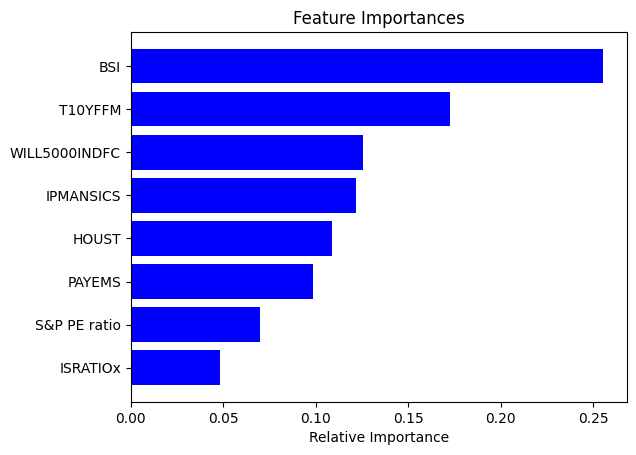

In [17]:
# Plotting feature importances
importances=model.feature_importances_
indices = np.argsort(importances)

features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Produce the feature importance plot with class contribution of each feature (global interpretability)

A variable importance plot lists the most significant variables in descending order. The top variables contribute more to the model than the bottom ones and thus have high predictive power

https://medium.com/dataman-in-ai/explain-your-model-with-the-shap-values-bc36aac4de3d

The following plot is made of all the dots in the train data. It delivers the following information:
Feature importance: Variables are ranked in descending order.
Impact: The horizontal location shows whether the effect of that value is associated with a positive or negative class

In [18]:
# explainer=shap.KernelExplainer(model.predict(X_train), n_samples=100)   
# shap_values = explainer.shap_values(X_train)
# explainer=shap.KernelExplainer(model.predict_proba, shap.sample(X_train, 12))  
# shap_values[0].shape

In [19]:
from sklearn.ensemble import RandomForestClassifier

# Need to load JS vis in the notebook
#shap.initjs()

# model=RandomForestClassifier(max_features=0.3,  class_weight='balanced', 
#                              n_estimators=30, n_jobs=-1, oob_score=True,
#                              random_state=14)

# model.fit(X_scaled_train, y_train)
explainer=shap.TreeExplainer(model, X_scaled_train)  
shap_values_train = explainer.shap_values(X_scaled_train, check_additivity=False)
shap_values_test = explainer.shap_values(X_scaled_test, check_additivity=False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


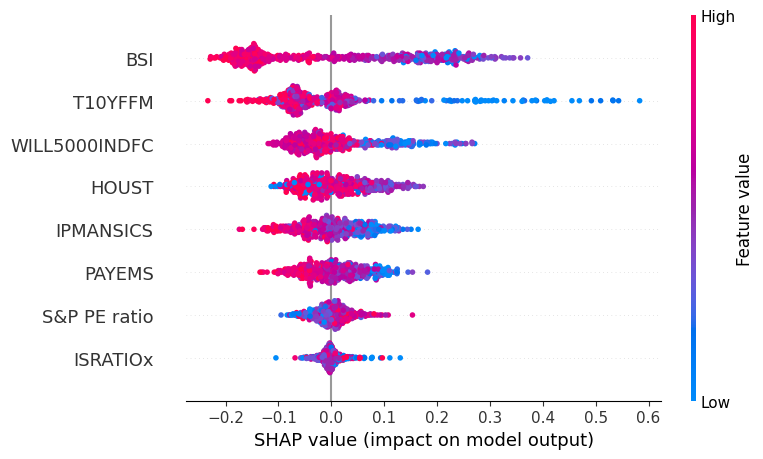

In [20]:
shap.summary_plot(shap_values_train[1], X_scaled_train)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


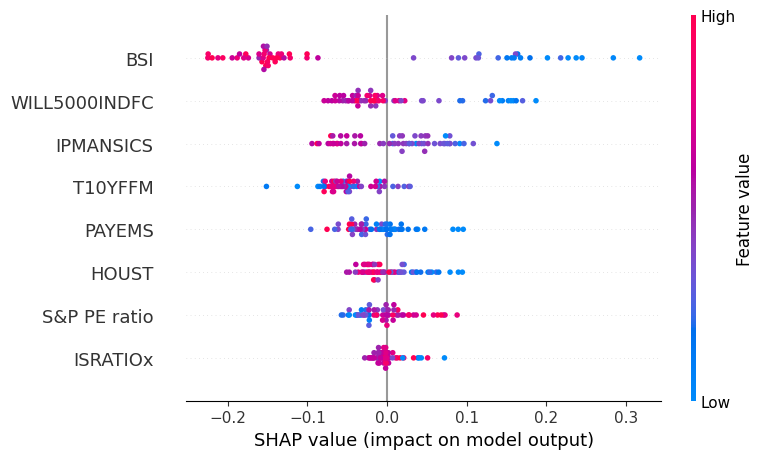

In [21]:
shap.summary_plot(shap_values_test[1], X_scaled_test)

In [22]:
# # torch.set_grad_enabled(True)
# #explainer=shap.DeepExplainer(model, X_train)   


# explainer=shap.TreeExplainer(model, X_scaled_train)  
# ##TreeExplainer(model) for rf, DeepExplainer() for LSTM, 
# ## Kernel Explainer(knn.predict_proba, X_train) for KNN
# ## Explainer(model.predict, X_train, algorithm='permutation')
# ## explainer=shap.KernelExplainer(model.predict_proba, shap.sample(X_train, 12))  
# shap_values = explainer.shap_values(X_scaled_train)
# #shap.summary_plot(shap_values, X_train, plot_type="bar")

# ## for saving the plots
# # import matplotlib.pyplot as plt
# # f = plt.figure()
# # shap.summary_plot(rf_shap_values, X_test)
# # f.savefig("/summary_plot1.png", bbox_inches='tight', dpi=600)

In [23]:
# with open('../result/explainer_nn.pkl','wb') as f:
#     pickle.dump(explainer, f)
    
# with open('../result/shap_val_nn.pkl','wb') as f:
#     pickle.dump(shap_values, f)
    

In [24]:
# ## shap.sample is same as sklearn.utils.resample(X, n_samples=nsamples, random_state=random_state)

# explainer2=shap.KernelExplainer(model.predict_proba, shap.sample(X_train, nsamples=200, random_state=14))   
# shap_values2= explainer.shap_values(X_test)

In [25]:
# with open('../result/explainer_sample_xtest.pkl','wb') as f:
#     pickle.dump(explainer2, f)
    
# with open('../result/shap_val_sample_xtest.pkl','wb') as f:
#     pickle.dump(shap_values2, f)

In [26]:
# explainer3=shap.KernelExplainer(model.predict_proba, X_train)   
# shap_values3= explainer.shap_values(X_test)

In [27]:
# X_train.shape

In [28]:
# shap_values[0].shape

The following plot shows feature importance for each class

- Feature importance: Variables are ranked in descending order.
- Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
- Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.
- Correlation: A high level of the “alcohol” content has a high and positive impact on the quality rating. The “high” comes from the red color, and the “positive” impact is shown on the X-axis. Similarly, we will say the “volatile acidity” is negatively correlated with the target variable.

In [29]:
# shap.summary_plot(shap_values[0], X_scaled_train)

plausible explanation: high value of T10YFFM particularly contribute to class0(expansion periods)
* likewise high value of BSI, T10YFFM, WILL5000INDFC, PAYEMS, HOUS, IPMANSICS are contributing positively to class0, while low value of S&P PE ratio, ISRATIOx are contributing positively to class0

In [30]:
# shap.summary_plot(shap_values[1], X_scaled_train)

plausible explanation: high value of BSI is particularly contributed to class0(expansion periods)
* likewise low value of BSI, PAYEMS, WILL5000INDFC, S&P PE ratio specifically related to mild recession
* the variable such as HOUST, WILL5000INDFC, shows ambivalent response. 

In [31]:
# if len(sorted(y_train.unique()))>2: 
#     shap.summary_plot(shap_values[2], X_scaled_train)

plausible explanation: all low values of the variables except ISRATIOx seems to be related to recession.
* for ISRATIOx, high value seems to related to recession (maybe due to lack of demands?) while IPMANSICS is low(low production but high inventories mean that there can be severe demand reduction)

In [32]:
list(metadata[metadata.id.isin(X_train.columns)].title)

['Industrial Production: Manufacturing (SIC)',
 'All Employees, Total Nonfarm',
 'New Privately-Owned Housing Units Started: Total Units',
 'Total Business:  Inventories to Sales Ratio',
 "S&P's Composite Common Stock: Price-Earnings Ratio",
 '10-Year Treasury Constant Maturity Minus Federal Funds Rate',
 'business survey(manufacturing):  Confidence indicators',
 'Wilshire 5000 Total Market Full Cap Index']

### SHAP Dependence Plot=PDP (global interpretability)

A partial dependence plot shows the marginal effect of one or two features on the predicted outcome of a machine learning model (J. H. Friedman 2001). It tells whether the relationship between the target and a feature is linear, monotonic or more complex

Let's firs look at our shape values: We have two arrays, one for each output class. The array sizes are the same size of the train dataset


In [33]:
# len(shap_values)       ## number of class(here 0,1,2)
# shap_values[0].shape, X_scaled_train.shape   ## training dataset * feature numbers

In [34]:
# var1='BSI'
# shap.dependence_plot(var1, shap_values[0], X_train)

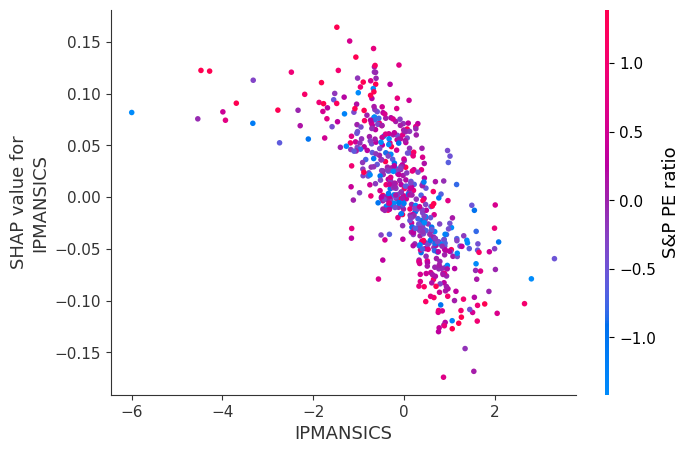

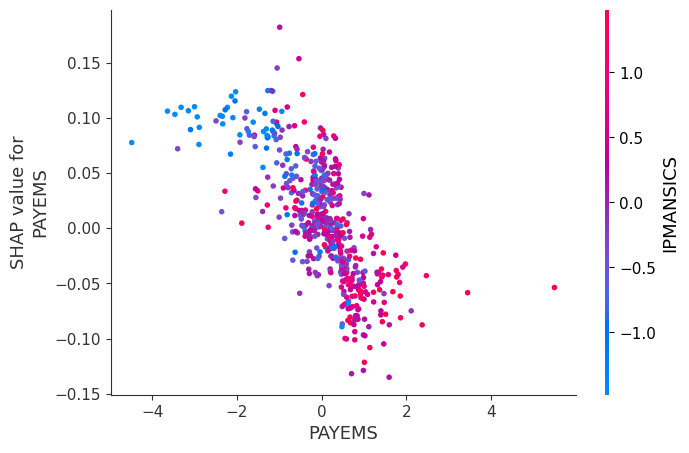

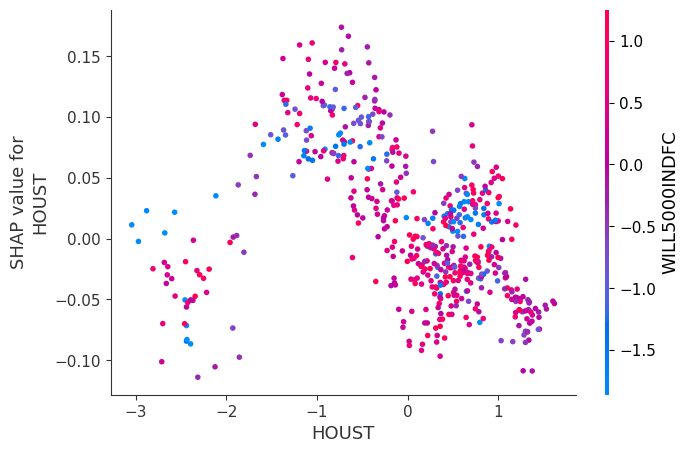

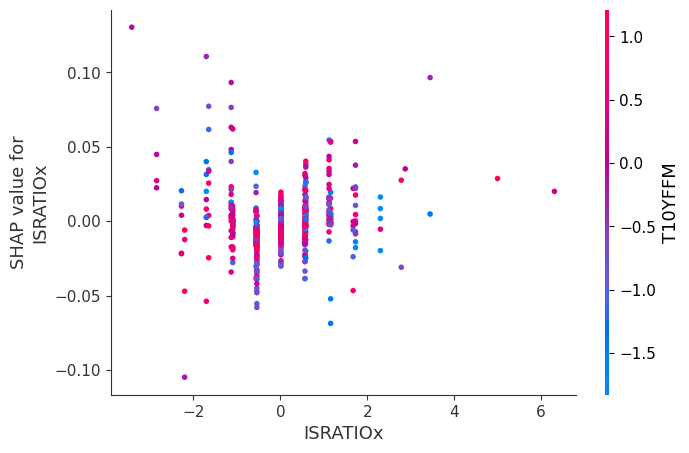

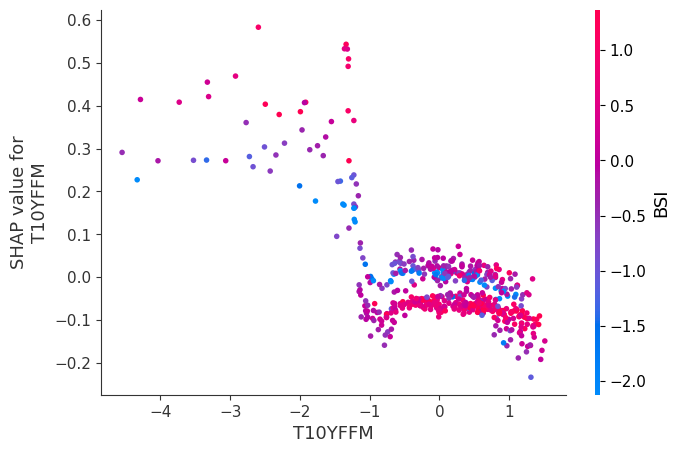

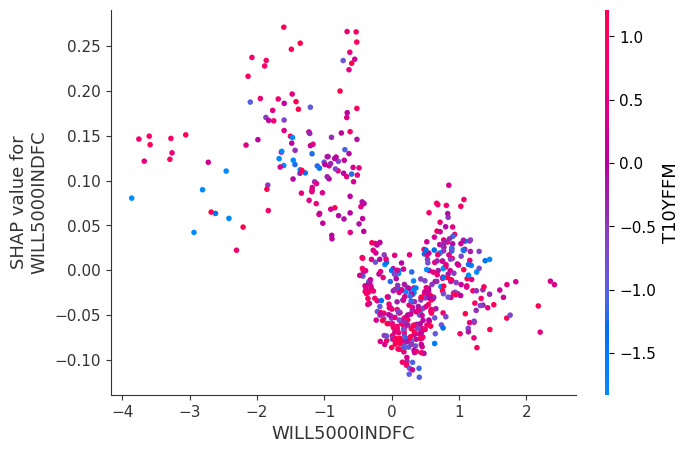

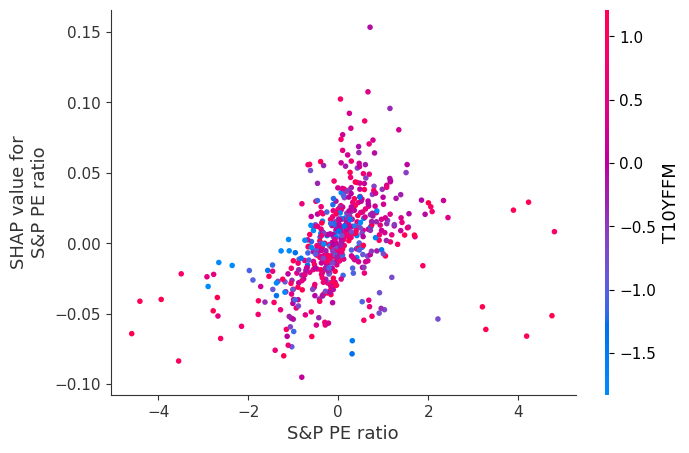

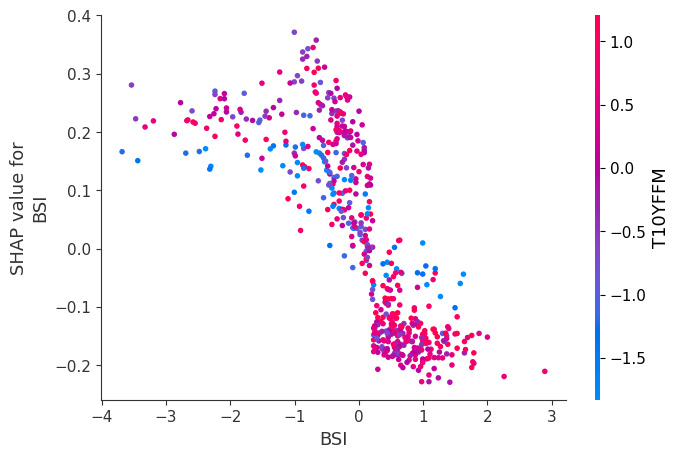

In [35]:
for var in list(X_train.columns):  ##var1='BSI'
# shap.dependence_plot(var1, shap_values[0], X_train)
    shap.dependence_plot(var, shap_values_train[1], X_scaled_train)
# if len(sorted(y_train.unique()))>2: 
#     shap.dependence_plot(var1, shap_values[2], X_train)

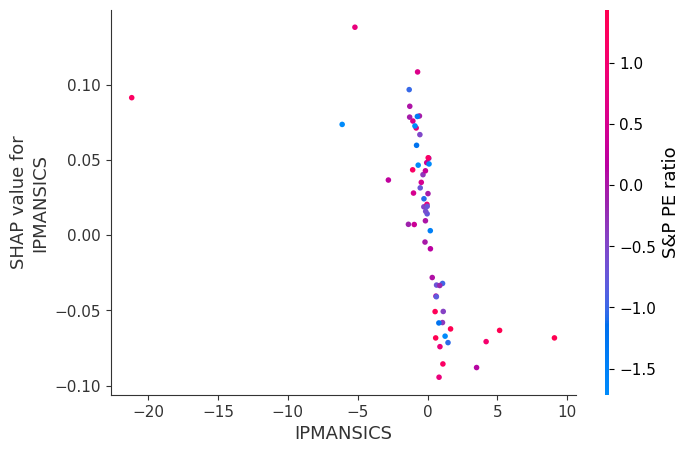

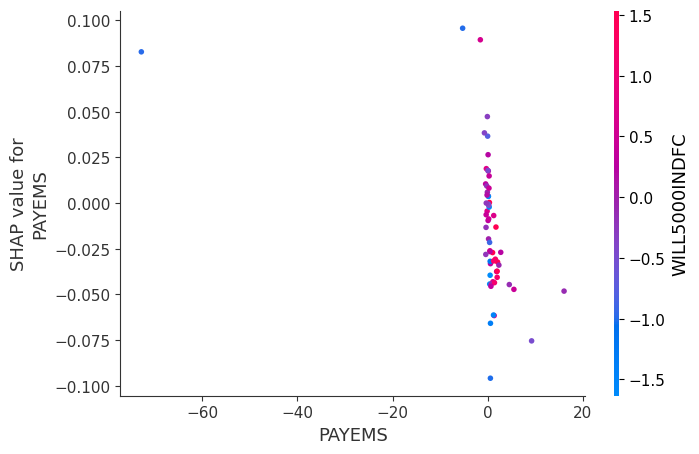

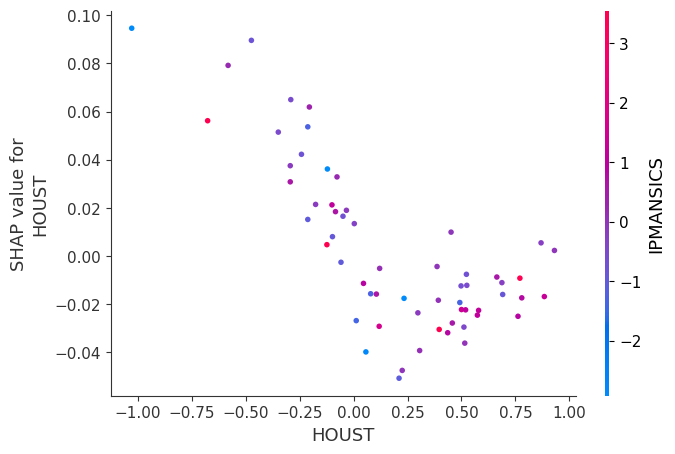

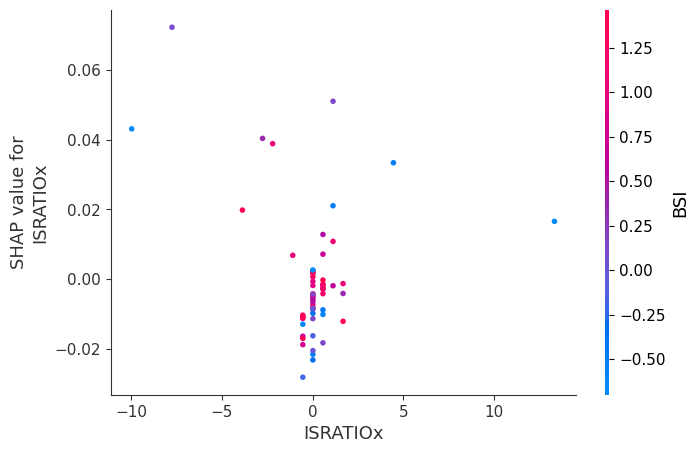

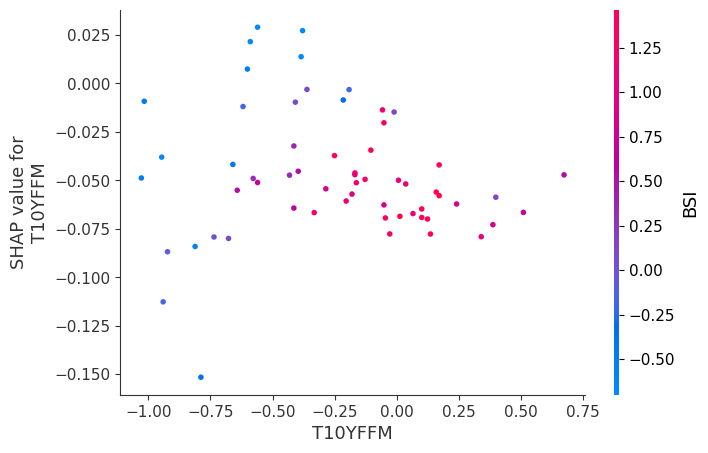

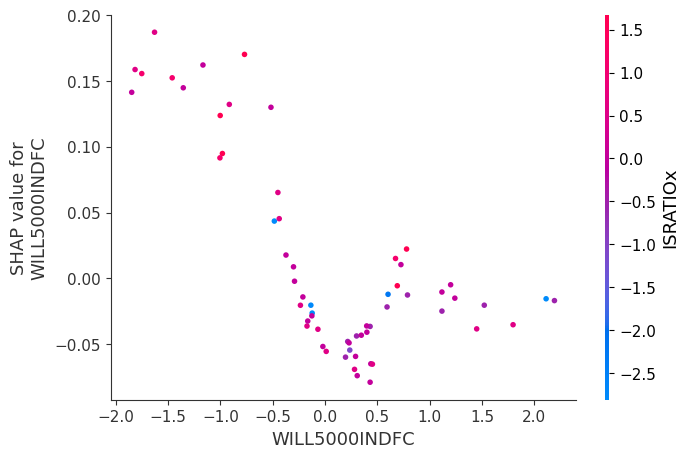

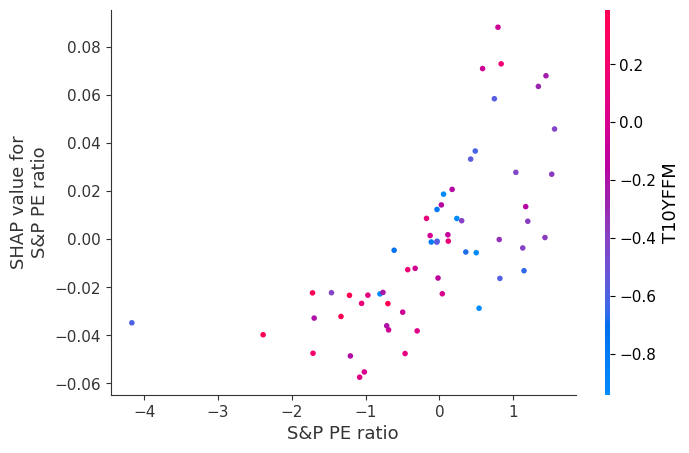

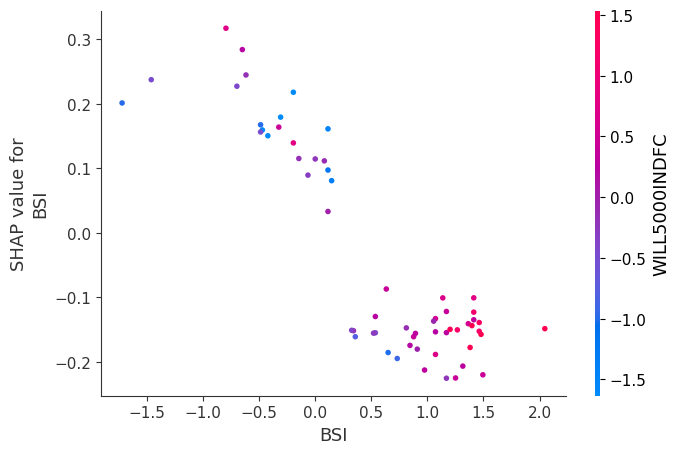

In [36]:
for var in list(X_test.columns):  ##var1='BSI'
# shap.dependence_plot(var1, shap_values[0], X_train)
    shap.dependence_plot(var, shap_values_test[1], X_scaled_test)
# if len(sorted(y_train.unique()))>2: 
#     shap.dependence_plot(var1, shap_values[2], X_train)

In [37]:
# metadata[metadata.id=='CMRMTSPLx'].title


- PAYEMS: the number of U.S. workers in the economy that excludes proprietors, private household employees, unpaid volunteers, farm employees, and the unincorporated self-employed. This measure accounts for approximately 80 percent of the workers who contribute to Gross Domestic Product (GDP).

- it shows quite strong negative relationship with recession while it shows positive relationship with recession though for recession period, the relationship of PAYEMS and target variable seems non-linear.

In [38]:
## for all classes, let's see how the prediction for 20.2 where true label was 2, 
## was decided and influenced by each feature.
## Determine which classes to show force plots for
# All classes 

#shap_values = explainer.shap_values(X_scaled_test)

idx_list=25
#idx_list=np.argwhere(y_test==2).flatten().tolist()

print('Expansion (0)')
display(shap.force_plot(explainer.expected_value[0],
            shap_values_test[0][idx_list],
            X_scaled_test.iloc[idx_list,:]))

print('Mild Recession (1)')
display(shap.force_plot(explainer.expected_value[1],
            shap_values_test[1][idx_list],
            X_scaled_test.iloc[idx_list,:]))

if len(sorted(y_train.unique()))>2: 
    print('Recession (2)')
    display(shap.force_plot(explainer.expected_value[2],
                shap_values_test[2][idx_list],
                X_scaled_test.iloc[idx_list,:]))



Expansion (0)


Mild Recession (1)


In [39]:
# ## for all classes, let's see how the prediction for 20.3 where true label was 2, 
# ## was decided and influenced by each feature.


# if len(sorted(y_train.unique()))>2: 
#     idx_list=np.argwhere(y_test==2).flatten().tolist()

#     for idx in idx_list:
#         print(y_test.index[idx])
#         shap.waterfall_plot(shap.Explanation(values=shap_values[2][idx], 
#                                              base_values=explainer.expected_value[2], 
#                                              data=X_test.iloc[idx],  
#                                              feature_names=X_test.columns.tolist()))
        
#     idx_list=np.argwhere(y_test==1).flatten().tolist()

#     for idx in idx_list:
#         print(y_test.index[idx])
#         shap.waterfall_plot(shap.Explanation(values=shap_values[1][idx], 
#                                              base_values=explainer.expected_value[1], 
#                                              data=X_test.iloc[idx],  
#                                              feature_names=X_test.columns.tolist()))    
        
# else:
#     idx_list=np.argwhere(y_test==1).flatten().tolist()

#     for idx in idx_list:
#         print(y_test.index[idx])
#         shap.waterfall_plot(shap.Explanation(values=shap_values[1][idx], 
#                                              base_values=explainer.expected_value[1], 
#                                              data=X_test.iloc[idx],  
#                                              feature_names=X_test.columns.tolist()))

2020-02-01 00:00:00


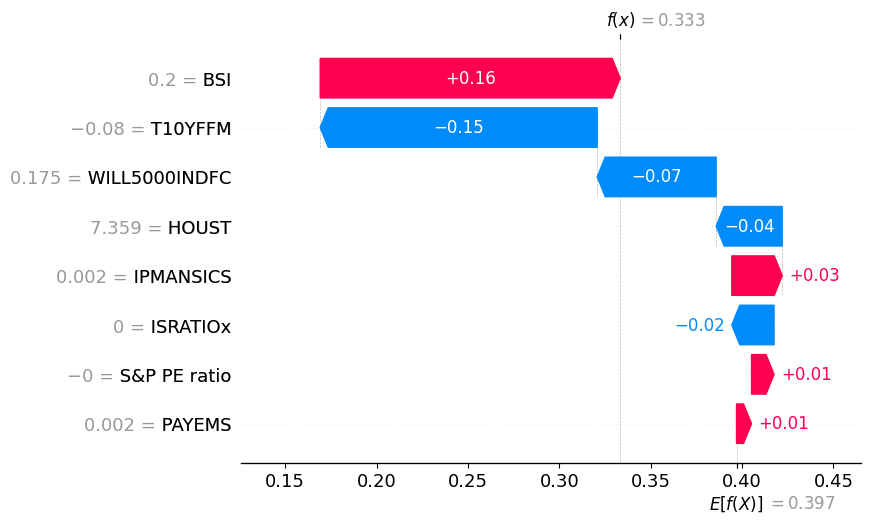

Expansion (0)


Recession (1)


<Figure size 640x480 with 0 Axes>

In [40]:
### error analysis (wrongly classified as 2, while true label=0): WILL5000INDFC, IPMANSICS is the main reason
## for all classes, let's see how the prediction for 22.11 where true label was 0, 
## was decided and influenced by each feature.


############## error analysis for false negative
idx_list_test=np.argwhere(y_test==1).flatten().tolist()
idx_list_pred=np.argwhere(y_pred==0).flatten().tolist()

idx_list=set(idx_list_test) & set(idx_list_pred)

for idx in idx_list:
    print(y_test.index[idx])
    shap.waterfall_plot(shap.Explanation(values=shap_values_test[1][idx], 
                                         base_values=explainer.expected_value[1], 
                                         data=X_test.iloc[idx],  
                                         feature_names=X_test.columns.tolist()))
    
    print('Expansion (0)')
    display(shap.force_plot(explainer.expected_value[0],
                shap_values_test[0][idx],
                X_scaled_test.iloc[idx]))

    print('Recession (1)')
    f = plt.figure()
    shap.force_plot(explainer.expected_value[1],
                shap_values_test[1][idx],
                X_scaled_test.iloc[idx])
    f.savefig("../result/err_fn.png", bbox_inches='tight', dpi=600)
    
    display(shap.force_plot(explainer.expected_value[1],
                shap_values_test[1][idx],
                X_scaled_test.iloc[idx]))
    
# import matplotlib.pyplot as plt
# f = plt.figure()
# shap.summary_plot(rf_shap_values, X_test)
# f.savefig("/summary_plot1.png", bbox_inches='tight', dpi=600)

In [41]:
### error analysis (wrongly classified as 2, while true label=0): WILL5000INDFC, IPMANSICS is the main reason
## for all classes, let's see how the prediction for 22.11 where true label was 0, 
## was decided and influenced by each feature.


############## error analysis for false negative
idx_list_test=np.argwhere(y_test==0).flatten().tolist()
idx_list_pred=np.argwhere(y_pred==1).flatten().tolist()

idx_list=set(idx_list_test) & set(idx_list_pred)

for idx in idx_list:
#     print(y_test.index[idx])
#     shap.waterfall_plot(shap.Explanation(values=shap_values_test[1][idx], 
#                                          base_values=explainer.expected_value[1], 
#                                          data=X_test.iloc[idx],  
#                                          feature_names=X_test.columns.tolist()))
    
#     print('Expansion (0)')
#     display(shap.force_plot(explainer.expected_value[0],
#                 shap_values_test[0][idx],
#                 X_scaled_test.iloc[idx]))

    print('Recession (1)', y_test.index[idx])
#     f = plt.figure()
#     shap.force_plot(explainer.expected_value[1],
#                 shap_values_test[1][idx],
#                 X_scaled_test.iloc[idx])
#     f.savefig("../result/err_fn.png", bbox_inches='tight', dpi=600)
    
    display(shap.force_plot(explainer.expected_value[1],
                shap_values_test[1][idx],
                X_scaled_test.iloc[idx]))
    
# import matplotlib.pyplot as plt
# f = plt.figure()
# shap.summary_plot(rf_shap_values, X_test)
# f.savefig("/summary_plot1.png", bbox_inches='tight', dpi=600)

Recession (1) 2019-08-01 00:00:00


Recession (1) 2019-09-01 00:00:00


Recession (1) 2022-06-01 00:00:00


Recession (1) 2019-11-01 00:00:00


Recession (1) 2019-12-01 00:00:00


Recession (1) 2022-09-01 00:00:00


Recession (1) 2022-07-01 00:00:00


Recession (1) 2022-11-01 00:00:00


Recession (1) 2022-12-01 00:00:00


Recession (1) 2022-08-01 00:00:00


Recession (1) 2022-10-01 00:00:00


In [42]:
metadata[metadata.id=='WILL5000INDFC']

,Unnamed: 0,tcode,id,group,source,title,frequency_short,units_short,seasonal_adjustment_short,last_updated,notes,start,end,group_kmean8
207,207,51,WILL5000INDFC,8,FRED,Wilshire 5000 Total Market Full Cap Index,D,Index,NSA,2023-05-31 07:04:05-05,The observations for the Wilshire 5000 Total M...,1971-02-01,2023-04-01,0.0


In [44]:
# shap_values[1][13]

In [46]:
### error analysis (wrongly classified as 1, while true label=0): IPMANSICS, HOUST is the main reason

## error analysis for false negative (Type2 error): recession but predicted as expansion 


# idx_list_test=np.argwhere((y_test==1)|(y_test==2)).flatten().tolist()
# idx_list_pred=np.argwhere(y_pred==0).flatten().tolist()

# idx_list=set(idx_list_test) & set(idx_list_pred)

# for idx in idx_list:
#     print("period: {}/{} (real label={}, predicted label={})".format(str(y_test.index[idx].year), 
#                                                                     str(y_test.index[idx].month),
#                                                                     int(y_test[idx]),
#                                                                     int(y_pred[idx])))
#     shap.waterfall_plot(shap.Explanation(values=shap_values[1][idx], 
#                                          base_values=explainer.expected_value[1], 
#                                          data=X_test.iloc[idx],  
#                                          feature_names=X_test.columns.tolist()))

In [47]:
def error_analysis_feature(real_label, pred_label, data):

    idx_list_test=np.argwhere(y_test==real_label).flatten().tolist()
    idx_list_pred=np.argwhere(y_pred==pred_label).flatten().tolist()

    idx_list=set(idx_list_test) & set(idx_list_pred)

    exp=shap.Explanation(values=shap_values[real_label],
                         base_values=explainer.expected_value[real_label], 
                         data=data.iloc,  
                         feature_names=data.columns.tolist())

    if idx_list!={}:
    
        for i, idx in enumerate(idx_list):
            if i==0:
                df_shap = pd.DataFrame({
                    'row_id':idx,
                    'ym':data.index[idx],
                    'feature': data.columns,
                    'base_value': exp[idx].base_values,
                    'shap_values': exp[idx].values,
                    'pred_label':pred_label,
                    'real_label':real_label
                })
            else:
                df_tmp=pd.DataFrame({
                    'row_id':idx,
                    'ym':data.index[idx],
                    'feature': data.columns,
                    'base_value': exp[idx].base_values,
                    'shap_values': exp[idx].values,
                    'pred_label':pred_label,
                    'real_label':real_label

                })
                df_shap = pd.concat([df_shap, df_tmp])


        pivot_df_shap=df_shap.pivot(index='ym', columns='feature', values='shap_values')
        min_df_shap=df_shap.groupby('ym').min().drop(columns='feature')
        max_df_shap=df_shap.groupby('ym').max().drop(columns='feature')
        min_df_shap['top_feature']=None
        max_df_shap['top_feature']=None

        for i in range(len(pivot_df_shap)):
            if min(pivot_df_shap.iloc[i])<0:
                neg_feature=pivot_df_shap.iloc[i].index[np.argmin(pivot_df_shap.iloc[i])]
            else:
                neg_feature=None
            if max(pivot_df_shap.iloc[i])>0:
                pos_feature=pivot_df_shap.iloc[i].index[np.argmax(pivot_df_shap.iloc[i])]
            else:
                pos_feature=None
            min_df_shap.loc[data.index[[*idx_list][i]],'top_feature']=neg_feature
            max_df_shap.loc[data.index[[*idx_list][i]], 'top_feature']=pos_feature

        return pd.concat([min_df_shap, max_df_shap])
    
    else:
        return None

    # # max_df_shap.loc[data.index[[*idx_list][0]], 'feature']


    # #data.index[[*idx_list][0]]

 
    # #sum_df_shap.iloc[1].index[np.argmin(sum_df_shap.iloc[1])]

In [49]:
# pred_label=0
# real_label=1
# data=X_test

# df_1_fn=error_analysis_feature(real_label, pred_label, data)
# df_1_fn.head()

In [50]:
# if len(sorted(y_train.unique()))>2:
#     pred_label=0
#     real_label=2
#     data=X_test

#     df2_fn=error_analysis_feature(real_label, pred_label, data)
#     df2_fn.head()

In [51]:
#df_shap.groupby('ym').min().drop(columns='feature')

The output value is the prediction for that observation (the prediction of the first row in Table (S)
The base value: The original paper explains that the base value E(y_hat) is “the value that would be predicted if we did not know any features for the current output.” In other words, it is the mean prediction, or mean(yhat).
Red/blue: Features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue.
xxxx: has a xxx impact on the class prediction. We can see what the value of this variable is in the table and compare to another instance to get further insite

 
The means of the variables are: X_train.mean() and comparison of each of the influencial variables to the mean will explain what the impact of this variable is when it is higher or lower than the mean. 

Summary to help understand SHAP values

- Each feature has a shap value contributing to the prediction.


- The final prediction = the average prediction + the shap values of all features.


- The shap value of a feature can be positive or negative.


- If a feature is positively correlated to the target, a value higher than its own average will contribute positively to the prediction.


- If a feature is negatively correlated to the target, a value higher than its own average will contribute negatively to the prediction.

# Classification metrics

### Confusion Matrix

https://towardsdatascience.com/understanding-the-confusion-matrix-and-how-to-implement-it-in-python-319202e0fe4d

https://medium.com/analytics-vidhya/evaluation-metrics-for-classification-problems-with-implementation-in-python-a20193b4f2c3

https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

A confusion matrix, also known as an error matrix, is a summarized table used to assess the performance of a classification model. The number of correct and incorrect predictions are summarized with count values and broken down by each class.

![Picture title](image-20230611-225742.png)

### Accuracy



This is simply equal to the proportion of predictions that the model classified correctly.

![Picture title](image-20230611-225848.png)

### Precision

Precision is also known as positive predictive value and is the proportion of relevant instances among the retrieved instances. In other words, it answers the question “What proportion of positive identifications was actually correct?”

![Picture title](image-20230611-225909.png)

### Recall

Recall, also known as the sensitivity, hit rate, or the true positive rate (TPR), is the proportion of the total amount of relevant instances that were actually retrieved. It answers the question “What proportion of actual positives was identified correctly?”

![Picture title](image-20230611-225922.png)

### Specificity

Specificity, also known as the true negative rate (TNR), measures the proportion of actual negatives that are correctly identified as such. It is the opposite of recall.

![Picture title](image-20230611-225953.png)

### F1 Score


The F1 score is a measure of a test’s accuracy — it is the harmonic mean of precision and recall. It can have a maximum score of 1 (perfect precision and recall) and a minimum of 0. Overall, it is a measure of the preciseness and robustness of your model.

![Picture title](image-20230611-230004.png)

In [52]:
# Confusion Matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[45 11]
 [ 1  3]]


<Axes: >

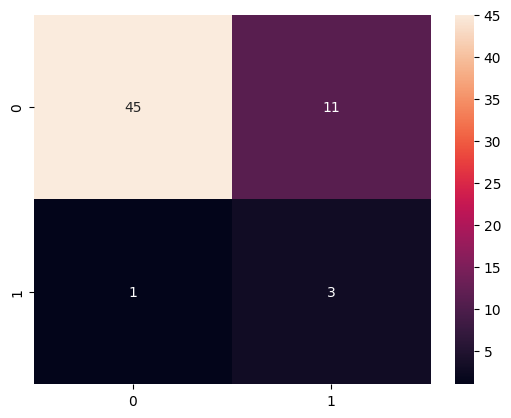

In [53]:
# Visualizing the confusion matrix

## row(y-axis=real value) vs. column(x-axis=prediction)
sns.heatmap(cf_matrix, annot=True)



<Axes: >

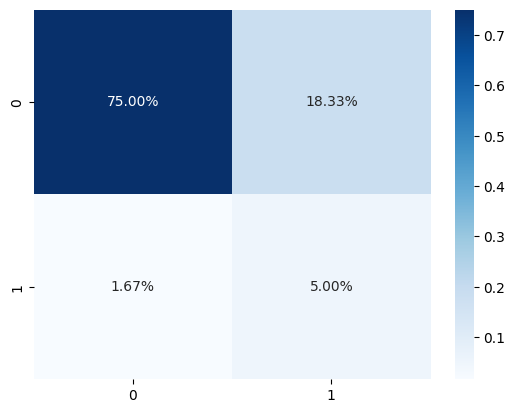

In [54]:
# Showing percentage of data represented in each quadrant
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [55]:
# Accuracy

accuracy = accuracy_score(y_test, y_pred)

# Recall
recall = recall_score(y_test, y_pred, average=None)

# Precision
precision = precision_score(y_test, y_pred, average=None)

In [56]:
print('Accuracy = ', accuracy,'/n', 'Recall = ',recall, '/n', 'Precision = ', precision)

Accuracy =  0.8 /n Recall =  [0.80357143 0.75      ] /n Precision =  [0.97826087 0.21428571]


In [57]:
# F1 Score Method 1: sklearn
f1_sk = f1_score(y_test, y_pred, average=None)

# F1 Score Method 2: Manual Calculation
F1_calc = 2 * (precision * recall) / (precision + recall)

# F1 Score Method 3: Classification report [BONUS]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.80      0.88        56
         1.0       0.21      0.75      0.33         4

    accuracy                           0.80        60
   macro avg       0.60      0.78      0.61        60
weighted avg       0.93      0.80      0.85        60



### AUC-ROC Curve

AUC-ROC Curve is a performance metric that is used to measure the performance for the classification model at different threshold values. ROC is Receiver Operating Characteristic Curve and AUC is Area Under Curve. The higher the value of AUC (Area under the curve), the better is our classifier in predicting the classes. AUC-ROC is mostly used in binary classification problems.

The ROC curve is plotted between True Positive Rate (TPR) and False Positive Rate (FPR) i.e. TPR on the y-axis and FPR on the x-axis. AUC is the area under the ROC curve. An excellent classifier has an AUC value near 1, whereas a poor-performing classifier has an AOC value near 0. A classifier with an AOC score of 0.5 doesn’t have any class separation capacity.

![Picture title](image-20230611-231939.png)

![Picture title](image-20230611-232000.png)

AUC for our classifier is: 0.7767857142857143


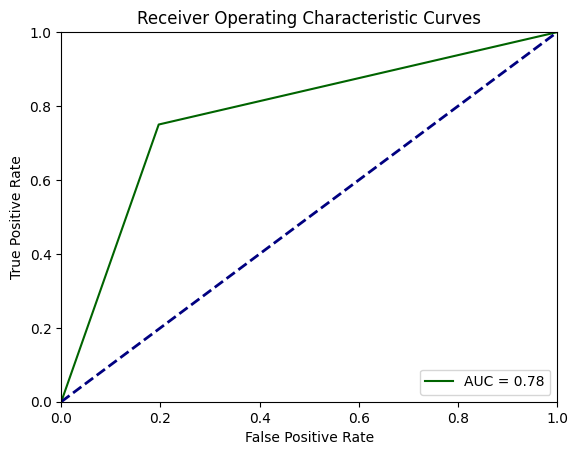

In [58]:
if len(sorted(y_train.unique()))==2:

    #class_probabilities = model.predict_proba(X_test)
    preds = y_pred_prob[:, 1]

    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Printing AUC
    print(f"AUC for our classifier is: {roc_auc}")

    # Plotting the ROC
    plt.title('Receiver Operating Characteristic Curves')
    plt.plot(fpr, tpr, 'darkgreen', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
else:
    #def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = model.predict_proba(X_test)

    #Binarize the output
    y_test_bin = label_binarize(y_test, classes=sorted(y_train.unique()))
    n_classes = y_test_bin.shape[1]

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

#     # calculate dummies once
#     fpr = dict()
#     tpr = dict()
#     roc_auc = dict()

    clist=['darkorange','limegreen','darkgreen']
    class_name=['expansion','mild recession','recession']

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        plt.plot(fpr[i], tpr[i], color=clist[i], lw=2,  label=class_name[i])
        print('AUC for Class {}: {}'.format(i, auc(fpr[i], tpr[i])))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curves')
    plt.legend()
    plt.show()

In [59]:
sorted({1,2,3})


[1, 2, 3]

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a63e5aef-5b52-4e97-916a-2439a8b479ff' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

In [60]:
def make_auc_dict(model_name, clf, labels, y_test, y_pred, y_pred_prob):

    dict_auc={'model':[], 'class':[], 'auc':[]}

    # 1이면, 1/2이면 각각의 auc score

    if len(labels)==2:

        #class_probabilities = model.predict_proba(X_test)
#        preds = y_pred_prob[:, 1]

        fpr, tpr, threshold = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)

        dict_auc['model'].append(model_name)
        dict_auc['class'].append(0)
        dict_auc['auc'].append(roc_auc)

        dict_auc['model'].append(model_name)
        dict_auc['class'].append(1)
        dict_auc['auc'].append(roc_auc)

    else:
        #def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
       ## y_score = ### model.predict_proba(X_test)

        #Binarize the output
        y_test_bin = label_binarize(y_test, classes=sorted(labels))
        n_classes = y_test_bin.shape[1]

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
                                    
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])  #y_score[:, i]
            dict_auc['model'].append(model_name)
            dict_auc['class'].append(i)
            dict_auc['auc'].append(auc(fpr[i], tpr[i]))

    return pd.DataFrame(dict_auc)

In [61]:
# with open ('../result/ft_None_0.3/clf_rf_y_agg_tr_block_t5_spl3.pkl'.format(model), 'rb') as f:
#     [clf, df_cvresult, y_pred, y_pred_prob, clf_report]=pickle.load(f)
    
# labels=[0,1,2]
# y_test=pd.read_csv('../data/y_data_tr.csv', index_col='date', parse_dates=True)['y_agg'][-(5*12):]
    
# make_auc_dict('clf_rf_y_agg_tr_block_t5_spl3', clf, labels, y_test, y_pred, y_pred_prob)

In [62]:
# dict_auc={'model':[], 'auc':[]}

# # 1이면, 1/2이면 각각의 auc score

# if len(labels)==2:

#     #class_probabilities = model.predict_proba(X_test)
# #        preds = y_pred_prob[:, 1]

#     fpr, tpr, threshold = roc_curve(y_test, y_pred)
#     roc_auc = auc(fpr, tpr)

#     dict_auc['model']=model_name
#     dict_auc['class']=0
#     dict_auc['auc']=roc_auc

#     dict_auc['model']=model_name
#     dict_auc['class']=1
#     dict_auc['auc']=roc_auc

# else:
#     #def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
#    ## y_score = ### model.predict_proba(X_test)

#     #Binarize the output
#     y_test_bin = label_binarize(y_test, classes=sorted(labels))
#     n_classes = y_test_bin.shape[1]

#     fpr = dict()
#     tpr = dict()
#     roc_auc = dict()

#     for i in range(n_classes):
#         fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])  #y_score[:, i]
#         dict_auc['model']=model_name
#         dict_auc['class']=i
#         dict_auc['auc']=auc(fpr[i], tpr[i])

In [63]:
# dict_auc

In [64]:
#roc_curve(y_test_bin[:, 0], y_pred_prob[:, 0])
# y_test_bin.shape

In [65]:
# # for each folder 
        
# #     use df_knn_report & rf_report => concat into df_report +add columns of threshold+None
# #     for model in whole models in the folder:
# #         calculate auc_dict
# #         concat all auc_dicts ==> auc_dict_df
# #     df_report.merge(auc_dict_df, model, class 기준)
    
# #     if first folder:
# #         df_final_report=df_report
# #     else:
# #         df_final_report=pd.concat(df_final_report, df_report)
    

# # df_final_report!!
    

# # metadata=pd.read_csv('../data/full_info.csv')

# def make_finalreport():

#     folders=[x for x in os.listdir("../result") if'ft' in x] 

#     for i, folder in enumerate(folders):
#     #    print(folder)
#         reports=[x for x in os.listdir("../result/{}".format(folder)) if 'creport' in x]
#         models=[x for x in os.listdir("../result/{}".format(folder)) if 'clf' in x]
#         ft_criteria=folder.split('_')[1]
#         ft_threshold=folder.split('_')[2]


#         path='../result/{}'.format(folder)

#         for k, report in enumerate(reports):
#             with open (path+'/{}'.format(report), 'rb') as f:
#                 df=pickle.load(f)
#             if k==0:
#                 df_report=df
#             else:    
#                 df_report=pd.concat([df_report, df])

#         df_report['ft_criteria']=ft_criteria    
#         df_report['ft_threshold']=ft_threshold

#         for j, model in enumerate(models):
#     #        print(model)
#             model_name=model.split('.')[0]
#             dtype=model.split('_')[4]
#             y_type=model.split('_')[2]+'_'+model.split('_')[3]
#             test_year=5

#             with open (path+'/{}'.format(model), 'rb') as f:
#                 [clf, df_cvresult, y_pred, y_pred_prob, clf_report]=pickle.load(f)


#             if dtype=='tr':
#                 X=pd.read_csv('../data/X_data_tr.csv', index_col='date', parse_dates=True)
#                 y=pd.read_csv('../data/y_data_tr.csv', index_col='date', parse_dates=True)
#             else:
#                 X=pd.read_csv('../data/X_data.csv', index_col='date', parse_dates=True)
#                 y=pd.read_csv('../data/y_data.csv', index_col='date', parse_dates=True)

#             labels=list(y[y_type].unique())    
#             y_test=y[y_type][-(test_year*12):]

#     ##        print(labels, y_type)

#             df_tmp=make_auc_dict(model_name, clf, labels, y_test, y_pred, y_pred_prob)
#     ##        print('auc df completed')
#     ##        print(df_tmp.head())

#             if j==0:
#                 df_auc=df_tmp
#             else:
#                 df_auc=pd.concat([df_auc, df_tmp])

#         df_report=df_report.merge(df_auc, left_on=['class','model'], right_on=['class','model'])

#         if i==0:
#             df_final_report=df_report
#         else:
#             df_final_report=pd.concat([df_final_report, df_report])
            
#     return df_final_report            

In [66]:
# df_final_report=make_finalreport()

In [67]:
# df1=df_final_report.groupby(['ft_criteria','ft_threshold','model']).max('class') ##[['auc']].reset_index()
# df1.reset_index().sort_values(['auc','recall','precision','accuracy'], ascending=[False, False, False, False])[:30]

# df2=df_final_report[df_final_report['class']>0].groupby(['ft_criteria','ft_threshold','model']).mean() ##[['auc']].reset_index()
# df2.reset_index().sort_values(['recall','auc'], ascending=[False, False])[:50]

# # df3=df_final_report.groupby(['ft_criteria','ft_threshold','model']).mean() ##[['auc']].reset_index()
# # df3.reset_index().sort_values(['recall','f1_score','precision','accuracy'], ascending=[False, False, False, False])[:50]


In [68]:
# y_train.value_counts()

In [69]:
# y_tr=pd.read_csv('../data/y_data_tr.csv', index_col='date', parse_dates=True)
# y=pd.read_csv('../data/y_data.csv', index_col='date', parse_dates=True)

# y_type='y_agg'

# y_train_tr=y[y_type][:-(test_year*12)]           
# y_test_tr=y[y_type][-(test_year*12):]


In [70]:
# y_train.value_counts(), y_test.value_counts()

In [71]:
# y_train_tr.value_counts(), y_test_tr.value_counts()

In [72]:
# model.get_params()